In [1]:
#| hide
%load_ext autoreload
%autoreload 2

In [30]:
from ids_finder.core.pipeline import ids_finder
from ids_finder.datasets import IDsDataset
from space_analysis.missions.psp.mag import load_data, download_data
# from ids_finder.missions.psp.mag import load_data, download_data

In [3]:
from sunpy.time import TimeRange
from numpy import timedelta64
from datetime import datetime, timedelta

In [4]:
start = '2019-04-06T12:00'
end = '2019-04-07T12:00'

earth_start = '2019-04-09'
earth_end = '2019-04-14'

In [5]:
psp_timerange = TimeRange(start, end)
timerange_earth = TimeRange(earth_start, earth_end)

In [6]:
def validate(timerange):
    if isinstance(timerange, TimeRange):
        return [timerange.start.to_string(), timerange.end.to_string()]

In [20]:
# tau = timedelta(seconds=60)
tau = timedelta(seconds=10)
ts = timedelta(seconds=1/264)

In [19]:
df = load_data(trange = validate(psp_timerange))

30-Jan-24 16:14:31 INFO     30-Jan-24 16:14:31: Downloading remote index:                           ]8;id=614933;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=739499;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#343\343]8;;\
                            https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2019/                        

30-Jan-24 16:14:33 INFO     30-Jan-24 16:14:33: File is current:                                    ]8;id=118496;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=642988;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#140\140]8;;\
                            /Users/zijin/data/psp/fields/l2/mag_rtn/2019/psp_fld_l2_mag_rtn_2019040                
                            612_v02.cdf                                                                            

                   INFO     30-Jan-24 16:14:33: File is current:                                    ]8;id=683300;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=324398;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#140\140]8;;\
                            /Users/zijin/data/psp/fields/l2/mag_rtn/2019/psp_fld_l2_mag_rtn_2019040                
                            618_v02.cdf                                                                            

                   INFO     30-Jan-24 16:14:33: File is current:                                    ]8;id=635612;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=495465;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#140\140]8;;\
                            /Users/zijin/data/psp/fields/l2/mag_rtn/2019/psp_fld_l2_mag_rtn_2019040                
                            700_v02.cdf                                                                            

30-Jan-24 16:14:34 INFO     30-Jan-24 16:14:34: File is current:                                    ]8;id=825454;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py\download.py]8;;\:]8;id=717861;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pyspedas/utilities/download.py#140\140]8;;\
                            /Users/zijin/data/psp/fields/l2/mag_rtn/2019/psp_fld_l2_mag_rtn_2019040                
                            706_v02.cdf                                                                            

In [21]:
candidate = ids_finder(df, tau, ts)

30-Jan-24 16:14:48 WARNING  30-Jan-24 16:14:48: DeprecationWarning: `pl.count()` is deprecated.       ]8;id=454880;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=30632;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            Please use `pl.len()` instead.                                                         
                                                                                                                   

                   WARNING  30-Jan-24 16:14:48: DeprecationWarning: `map_alias` is deprecated. It has ]8;id=451937;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=343318;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been moved to `name.map`.                                                              
                                                                                                                   

                   WARNING  30-Jan-24 16:14:48: DeprecationWarning: `map_alias` is deprecated. It has ]8;id=321312;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=990673;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been moved to `name.map`.                                                              
                                                                                                                   

30-Jan-24 16:14:50 WARNING  30-Jan-24 16:14:50: UserWarning: Converting non-nanosecond precision      ]8;id=363806;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=380551;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            datetime values to nanosecond precision. This behavior can eventually be               
                            relaxed in xarray, as it is an artifact from pandas which is now                       
                            beginning to support non-nanosecond precision values. This warning is                  
                            caused by passing non-nanosecond np.datetime64 or np.timedelta64 values                
                            to the DataArray or Variable constructor; it can be silenced by                        
                            converting the values to nanosecond precision ahead of time.                           
                                                                                                                   

                   WARNING  30-Jan-24 16:14:50: UserWarning: Distributing <class                      ]8;id=711237;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=87808;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            'pandas.core.frame.DataFrame'> object. This may take some time.                        
                                                                                                                   

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     30-Jan-24 16:14:50: Using sequential splitting in               ]8;id=806559;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=64125;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            '.from_pandas()' because of some of the conditions are False:                          
                            enough_elements=False; all_numeric_types=False;                                        
                            async_mode_on=False                                                                    

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

30-Jan-24 16:14:51 INFO     30-Jan-24 16:14:51: Using sequential splitting in               ]8;id=756448;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=441371;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            '.from_pandas()' because of some of the conditions are False:                          
                            enough_elements=False; all_numeric_types=False;                                        
                            async_mode_on=False                                                                    

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     30-Jan-24 16:14:51: Using sequential splitting in               ]8;id=910604;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=673746;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            '.from_pandas()' because of some of the conditions are False:                          
                            enough_elements=False; all_numeric_types=True;                                         
                            async_mode_on=False                                                                    

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

                   INFO     30-Jan-24 16:14:51: Using sequential splitting in               ]8;id=400420;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py\partition_manager.py]8;;\:]8;id=188912;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/modin/core/execution/ray/implementations/pandas_on_ray/partitioning/partition_manager.py#89\89]8;;\
                            '.from_pandas()' because of some of the conditions are False:                          
                            enough_elements=False; all_numeric_types=False;                                        
                            async_mode_on=False                                                                    

In [22]:
psp_ids_dataset = IDsDataset(
    candidates = candidate,
    data = df
)

Examples of discontinuities observed by PSP

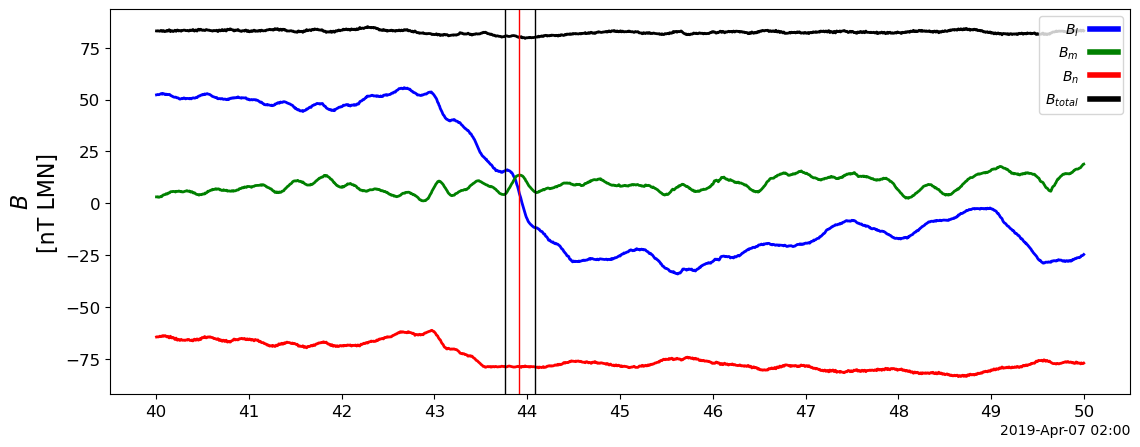

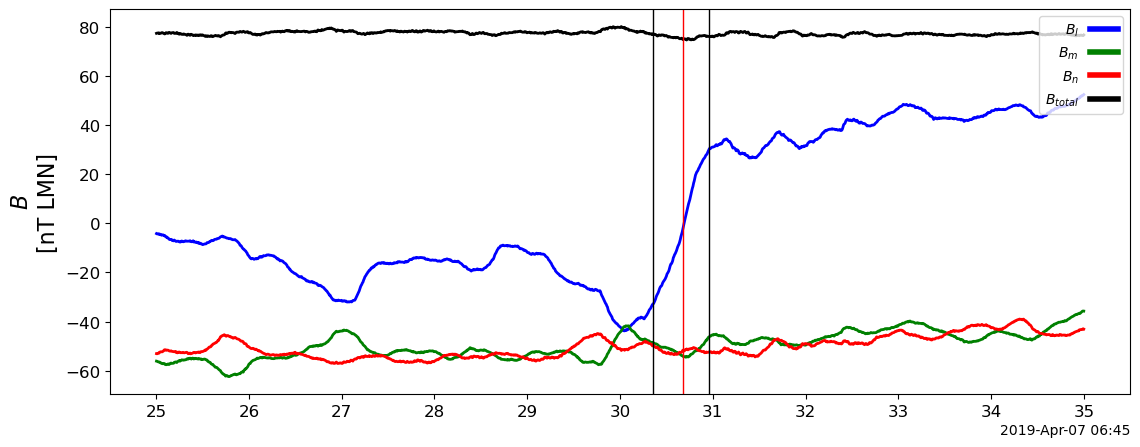

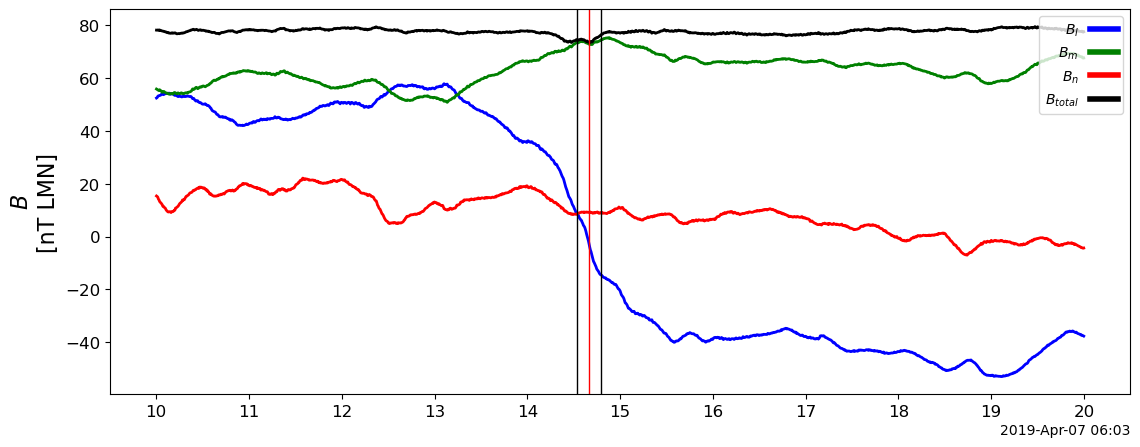

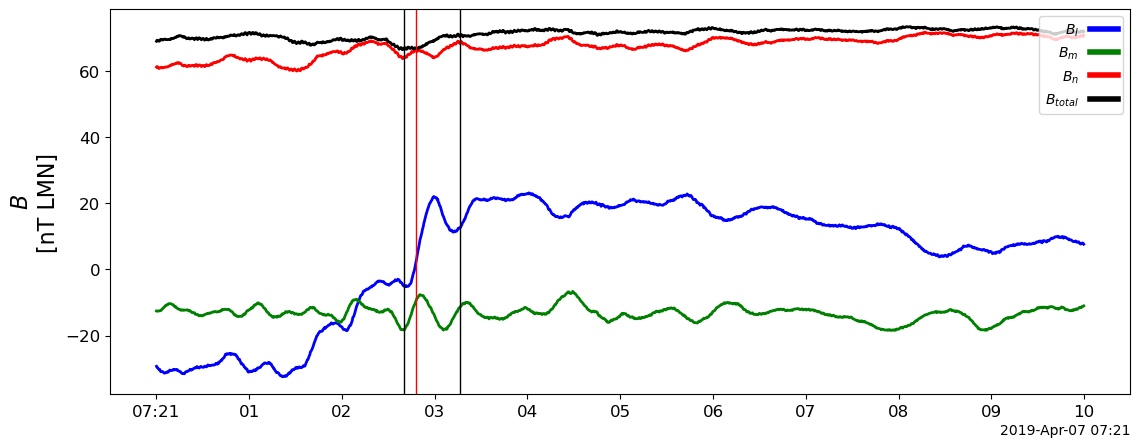

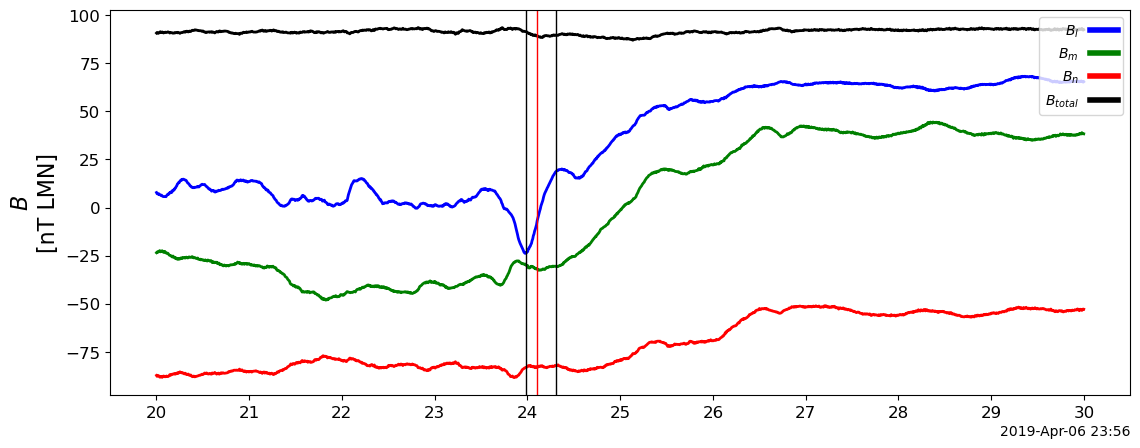

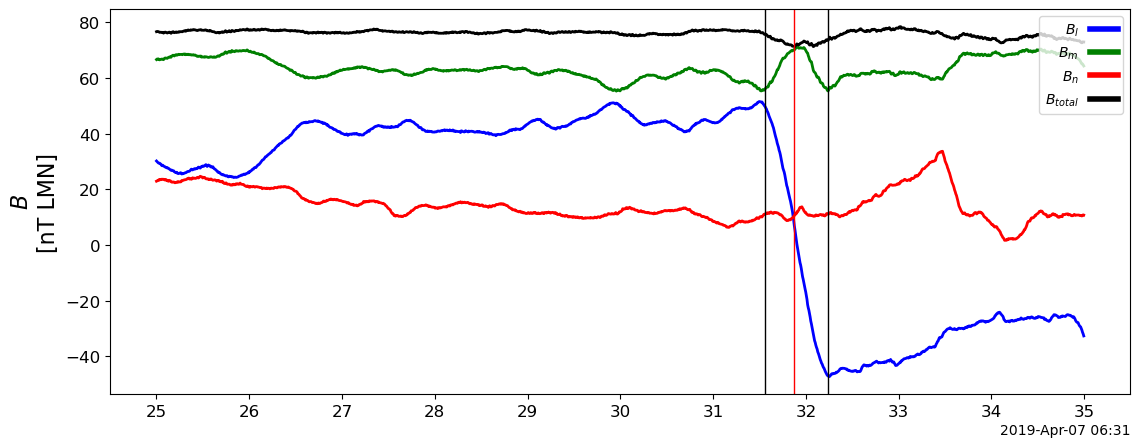

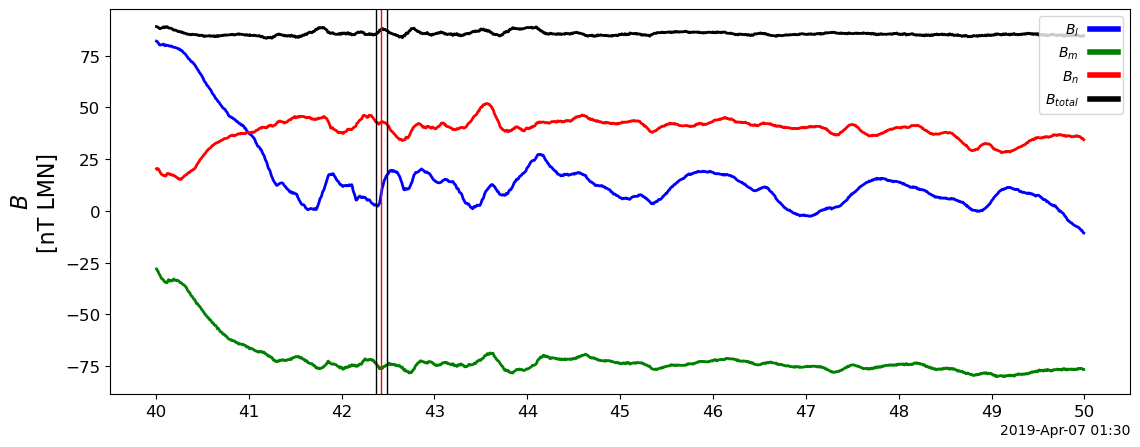

In [54]:
#| column: screen
#| layout-ncol: 2

good_indices = [87, 285, 121, 128, 69, 282, 81]
figs = psp_ids_dataset.plot_candidates(good_indices, display=False)

2024-01-30 16:26:29.238 | INFO     | ids_finder.datasets:plot_candidates:64 - Candidates indices: [282, 32, 148, 81]


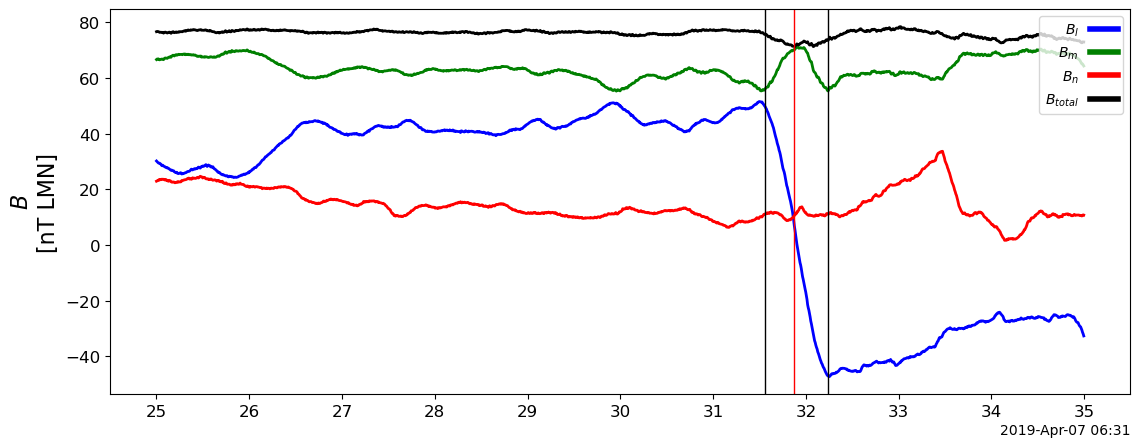

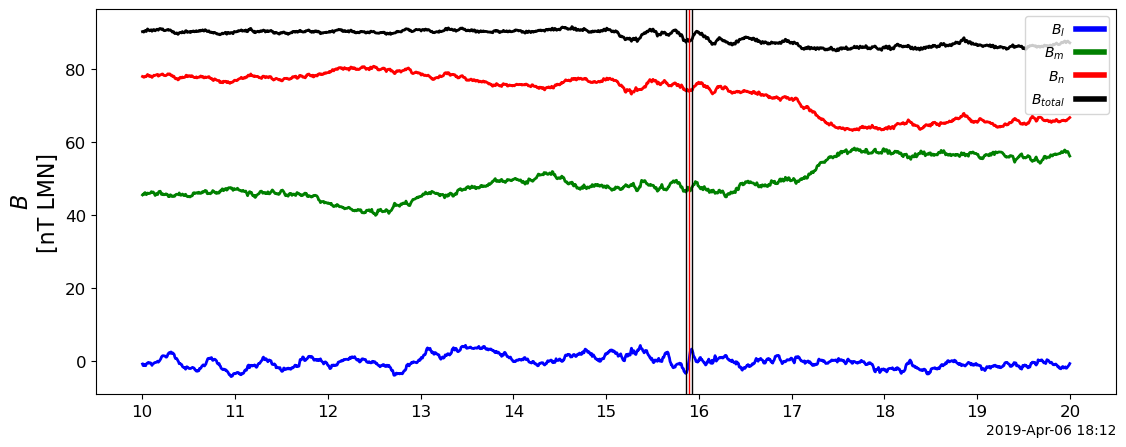

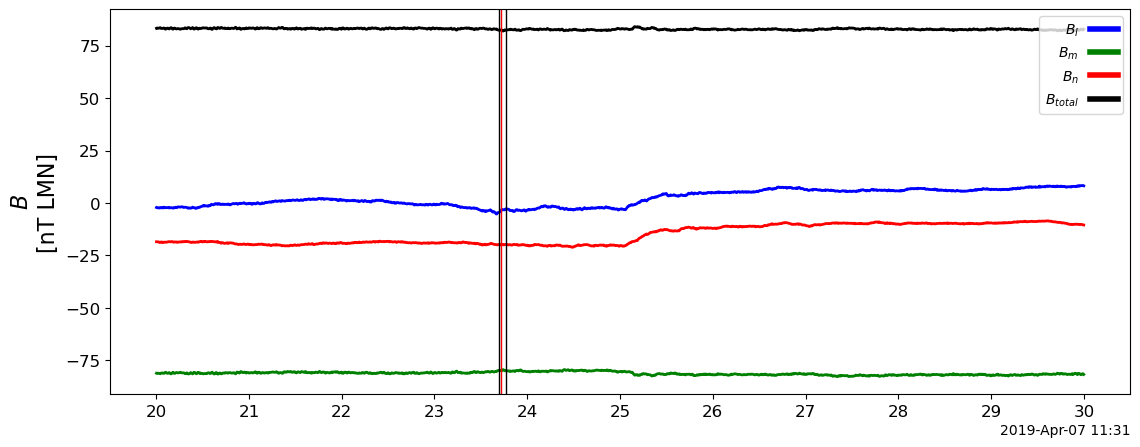

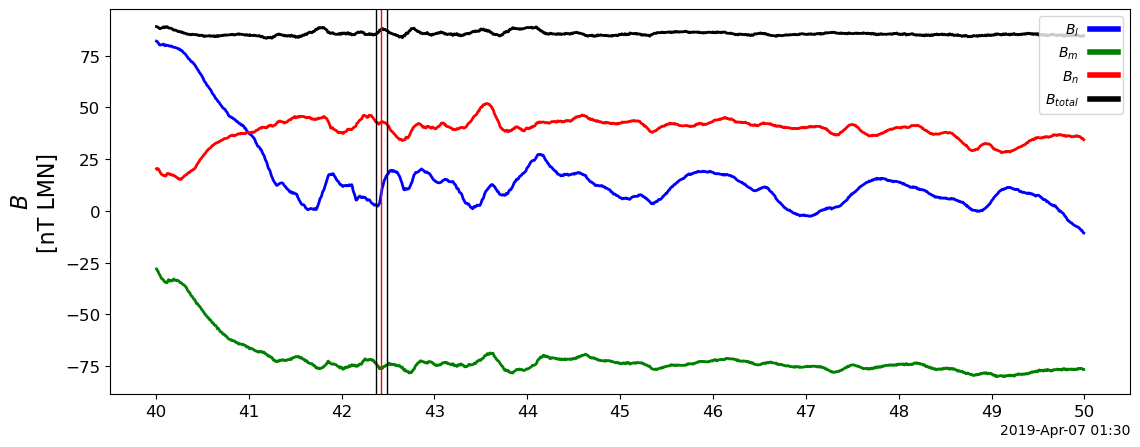

In [42]:
psp_ids_dataset.plot_candidates()